In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods):
    x1 = -0.5*L_p
    # ncy = 20

    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    
    xx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    xx_ref = torch.linspace(0, 1-1/ncx1, ncx1)
    xx[0:ncx1] = -L_p*(1 - xx_ref) + x1*xx_ref 
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + x2 * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = x2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + 0*xx_ref
    
    yy = torch.zeros(ncx+1, dtype=torch.float).to(device)
    yy_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    yy[ncx1:ncx1+ncx2] = 0*(1 - yy_ref) + h*yy_ref
    yy_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    yy[ncx1+ncx2:ncx1+ncx2+ncx3] = h*(1 - yy_ref) + 0*yy_ref
    
    

    X_Y = torch.zeros((1, n_periods*ncx+1, 2), dtype=torch.float).to(device)
    X_Y[0, -(ncx + 1):, 0], X_Y[0, -(ncx + 1):, 1] = xx, yy
    for i_period in range(1,n_periods):
        X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 0], X_Y[0, -((i_period + 1)*ncx + 1):-(i_period*ncx), 1] = xx-i_period*L_p, yy
       
    
    return X_Y, xx, yy


def Theta2Mesh_1d(L_p, x2, x3, h):
    ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
    n_periods = 10
    X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)
    return X_Y, X, Y

[633.           5.04531     66.47064381 -33.2353219  -19.95194009
 -18.2054513   28.37515941]
sample =  633.0
min loss =  270201.8820477514 L_p, x2, x3, h =  66.4706438090214 -19.951940091279496 -18.2054512952964 28.3751594056055


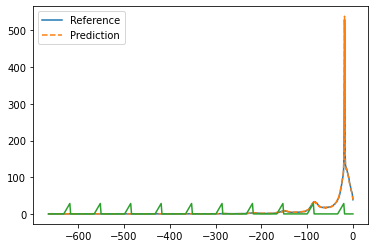

In [3]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
ncx = ncx1 + ncx2 + ncx3 + ncx4


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
    all_loss[i] = -np.dot(output[:,i], xx_mask) * L_p*n_periods/(n_periods*ncx+1)

    

loss_min_ind = np.argmin(all_loss)
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
loss_min = all_loss[loss_min_ind]
model = torch.load("catheter_plain_period_model_1d500", map_location=device)
X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()

print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out, "--", label="Prediction")
plt.plot(mesh_X, mesh_Y)
plt.legend()

In [4]:
inputPara.shape

(7, 1000)

1d X error =  2.22844987938144e-05
1d Y error =  7.89796405869595e-06
L_p, x1, x2, x3, h  =  85 -42.5 -32 -30 30
loss =  1350013.1610193192


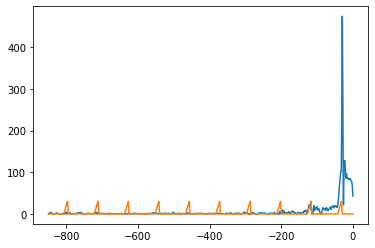

In [5]:
L_p, x2, x3, h = 85, -32, -30, 30
x1 = -0.5*L_p
n_periods = 10
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
ncx = ncx1 + ncx2 + ncx3 + ncx4
X0,Y0 = numpy_catheter_mesh_1d_single_period(L_p, x1, x2, x3, h, ncx1, ncx2, ncx3, ncx4)
X_Y, X, Y = catheter_mesh_1d_single_period(L_p, x2, x3, h, ncx1, ncx2, ncx3, ncx4, n_periods)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()

##################################################
# Prediction on a special design
#################################################
model = torch.load("catheter_plain_period_model_1d500", map_location=device)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
print("loss = ",  -np.dot(out,xx_mask) )
plt.figure()
plt.plot(xx_mask, out)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1])


82373057
0 0.062304615043103695 loss =  282428.5625
L_p, x1, x2, x3, h  =  66.47064208984375 -33.235321044921875 -19.951940536499023 -18.2054500579834 28.375160217285156


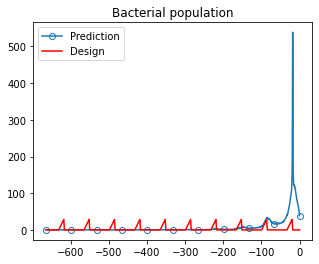

200 0.05654102377593517 loss =  281133.09375
L_p, x1, x2, x3, h  =  66.45706939697266 -33.22853469848633 -20.50186538696289 -18.198711395263672 28.175052642822266


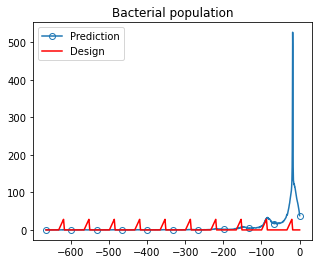

400 0.05646886955946684 loss =  280046.5625
L_p, x1, x2, x3, h  =  66.4421615600586 -33.2210807800293 -20.464290618896484 -18.191307067871094 27.970672607421875


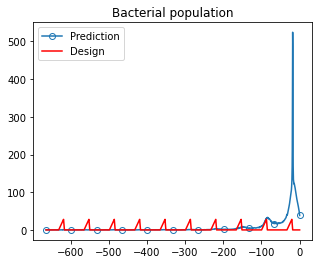

600 0.056491472758352757 loss =  279182.53125
L_p, x1, x2, x3, h  =  66.42743682861328 -33.21371841430664 -20.651182174682617 -18.183996200561523 27.784530639648438


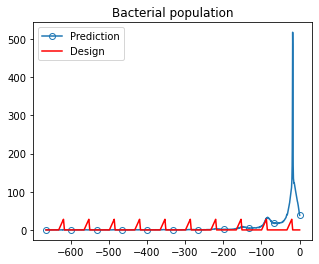

800 0.05642050411552191 loss =  278635.34375
L_p, x1, x2, x3, h  =  66.41309356689453 -33.206546783447266 -20.892370223999023 -18.176876068115234 27.613794326782227


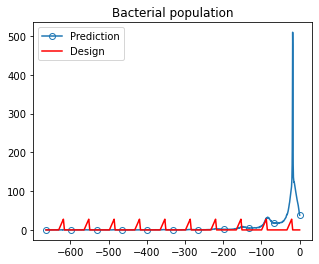

1000 0.05639405827969313 loss =  278358.78125
L_p, x1, x2, x3, h  =  66.39907836914062 -33.19953918457031 -20.535274505615234 -18.1699161529541 27.459686279296875


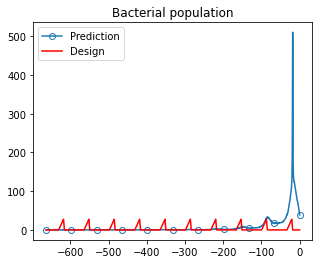

KeyboardInterrupt: 

In [6]:
################################################################
# inverse optimization for 1d
################################################################
n_periods = 10

model = torch.load("catheter_plain_period_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.0001
epochs = 10001
step_size = 1000
gamma = 0.5


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
def transfer(theta):
    
    L_p = 60 + (150 - 60)/(1 + torch.abs(theta[0]))
    x1 = -0.5*L_p
    x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
    h = 20   + (10)/(1 + torch.abs(theta[3]))
    return L_p, x1, x2, x3, h
   
def inv_transfer(L_p, x2, x3, h):
    theta = np.zeros(4)
    theta[0] = (150 - 60)/(L_p - 60) - 1
    theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
    theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
    theta[3] = 10/(h - 20 ) - 1
    return theta

sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
theta0 =    inv_transfer(L_p, x2, x3, h) 

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)



ncx = 200
n_periods = 10
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = Theta2Mesh_1d(L_p, x2, x3, h)
    
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    xx_mask = (torch.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)).to(device)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_p*n_periods/(n_periods*ncx+1)
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

In [ ]:
a = x.detach().cpu().numpy()
plt.plot(a[0,:,0], a[0,:,1])